## 1. Resultados del Análisis Exploratorio 
En esta sección se discutirán los resultados del Análisis Exploratorio para el modelo de Cantidades Vendidas (*sold_quantity*). Se considera que con el conocimiento obtenido hasta el momento es posible identificar con una precisión adecuada cuándo un producto no ha vendido unidades (*sold_quantity = 0*). Sin embargo, poder discriminar entre el resto de categorías parece ser una tarea bastante complicada, por lo menos con la información recolectada hasta el momento. 

Por lo anterior se propone probar con dos modelos. 

- **Modelo 1:** Predicción de *sold_quantity* directamente
- **Modelo 2:** Predicción de cinco categorías: 0 unidades vendidas, [1 - 4] unidades vendidas, [5 - 25], (25, 50], 50+ unidades vendidas.
    - Este último podría utilizarse para predecir grupos sobre los cuáles utilizar un modelo específico. 
    
Y se comparará directamente su desempeño con una predicción basada en la moda por años de antigüedad, corregida por:
- **Tipo de comisión:** Diferente a *gold_pro* o *gold_special* > Predicción 0
- **Condición del Producto:** Usado -> Predicción 0

Los modelos serán árboles boosteados (XGBoost), y por cuestiones de tiempo, sólo se hará una búsqueda del número óptimo de árboles de los modelos de clasificación.

### 1.1 Selección de Variables para Modelamiento

Gracias al Análisis Exploratorio, se identificaron que las variables que tenían más relación con la variable objetivo de cantidad vendida fueron: 
- **golden_categories**: Una variable indicadora que toma el valor de 1 si la comisión asociada al producto es *golden_pro* o *golden_special*. Toma el valor de 0 en caso contrario.
- **is_new**: Una variable indicadora que toma el valor de 1 si el producto es nuevo o 0 si es usado.
- **total_questions**: Cantidad de preguntas que tiene el producto.
- **product_age**: Antigüedad del producto en meses.
- **has_discount**: Variable que indica si el producto tiene un descuento (1) o no (0). 
- **updated_picture**: Variable que indica si el producto tiene una imagen actualizada (1) o no (0).

A continuación construyen estas variables y se divide la muestra en conjuntos de entrenamiento (64%), validación (16%) y prueba (20%). 

## 2. Cargue de Información

In [26]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from model import plot_confusion_matrix, GridSearchXGBClassifier, benchmark
from sklearn.model_selection import train_test_split
import numpy as np

### 2.1 Creación de Features

In [2]:
data_folder = '../data'
data_by_category = [pd.read_csv(os.path.join(data_folder, file), sep = ";") for file in os.listdir('../data') if file.find('.csv') != -1]
complete_df = pd.concat(data_by_category, axis = 0, ignore_index=True)

# Indicador de Categoría Dorada
complete_df['golden_categories'] = 1*(complete_df.listing_type_id.isin(['gold_pro', 'gold_special']))

# Indicador de Producto Nuevo
complete_df['is_new'] = 1*(complete_df.condition=='new')

# Antigüedad de Producto
actual_year = 2020
actual_month = 12
complete_df['product_age'] = 12*(actual_year - complete_df.year_created) + (actual_month - complete_df.month_created) + 1

# Indicador de descuento
complete_df['has_discount'] = 1*(~complete_df.original_price.isnull())

# Se crea una característica indicando si la foto fue actualizada
complete_df.loc[(complete_df.year_update == complete_df.year_created) & (complete_df.month_update == complete_df.month_created), 'updated_picture'] = 0
complete_df.loc[(complete_df.year_update != complete_df.year_created) | (complete_df.month_update != complete_df.month_created), 'updated_picture'] = 1

### 2.2. Creación de Variable Objetivo para Modelo 2

In [3]:
complete_df.loc[complete_df.sold_quantity == 0, 'sold_group'] = 0   # 0
complete_df.loc[complete_df.sold_quantity >= 1, 'sold_group'] = 1   # De [1, 4]
complete_df.loc[complete_df.sold_quantity == 5, 'sold_group'] = 5   # De [5, 25]
complete_df.loc[complete_df.sold_quantity >= 25, 'sold_group'] = 25 # De [26 - 50)
complete_df.loc[complete_df.sold_quantity >= 50, 'sold_group'] = 50 # De 50 +

In [ ]:
complete_df.sold_group.value_counts()/len(complete_df) 

Se puede apreciar que esta re-categorización vuelve el conjunto de datos más balanceado. Por lo que utilizar el acierto de clasificación (accuracy) no sería tan engañoso.

In [4]:
features = ['golden_categories', 'is_new','total_questions', 'product_age', 'has_discount' , 'updated_picture']
target_1 = ['sold_quantity']
target_2 = ['sold_group']

## 3. Modelamiento

### 3.1 Modelo de Categoría Vendida

In [5]:
X = complete_df[features].copy()
y = complete_df[target_1].astype('int64').copy()

#X.product_age.fillna(X.product_age.median(), inplace=True)
X.total_questions.fillna(0, inplace=True)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [8]:
print(f'Number of Categories: {len(y_train.value_counts())}')

Number of Categories: 14


#### 3.1.1 XGBoost Classifier

In [16]:
Model_1 = GridSearchXGBClassifier(num_class = 14)
Model_1.fit(X_train, y_train)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   37.1s finished
/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_class=14, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_al

#### 3.1.2 Benchmark para Cantidad Vendida

In [19]:
benchmark_1 = benchmark()
benchmark_1.fit(X_train, y_train)

#### 3.1.3 Predicciones y Evaluación de Modelos

In [20]:
# Predicciones en Validación y Test para el Modelo 1
predictions_model_1_validation = Model_1.predict(X_val)
f_1_model_1_validation = f1_score(predictions_model_1_validation, y_val.values, average = 'macro')

predictions_model_1_test = Model_1.predict(X_test)
f_1_model_1_test = f1_score(predictions_model_1_test, y_test.values, average = 'macro')

In [21]:
# Predicciones en Validación y Test para Benchmark 1
predictions_bench_1_validation = benchmark_1.predict(X_val)
f_1_bench_1_validation = f1_score(predictions_bench_1_validation, y_val.values, average = 'macro')

predictions_bench_1_test = benchmark_1.predict(X_test)
f_1_bench_1_test = f1_score(predictions_bench_1_test, y_test.values, average = 'macro')

In [22]:
print(f'Resultados Validación: F1 Modelo {f_1_model_1_validation} vs. F1 Benchmark {f_1_bench_1_validation}\nResultados Test: F1 Modelo {f_1_model_1_test} vs F1 Benchmark {f_1_bench_1_test}')

Resultados Validación: F1 Modelo 0.2171963562188411 vs. F1 Benchmark 0.08699147442574076
Resultados Test: F1 Modelo 0.21374902117913736 vs F1 Benchmark 0.08712369419456757


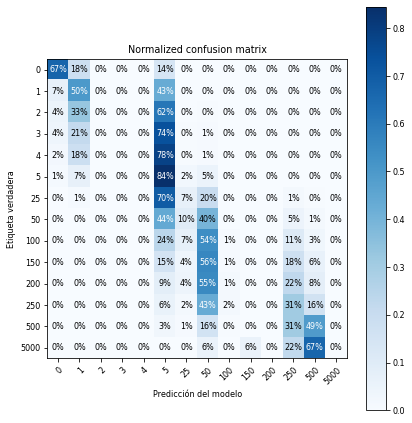

In [30]:
cf_M1 = plot_confusion_matrix(y_test.values, predictions_model_1_test, np.unique(y_test.values), normalize=True)

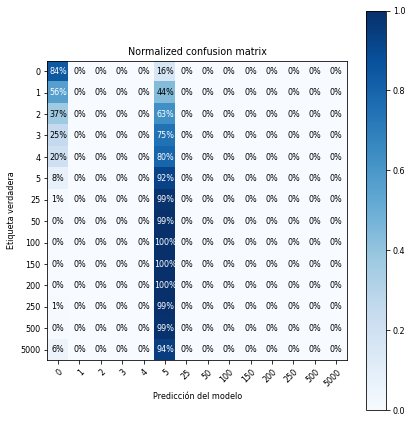

In [31]:
cf_B1 = plot_confusion_matrix(y_test.values, predictions_bench_1_test, np.unique(y_test.values), normalize=True)

### 3.2 Modelo Grupos de Categoría

In [32]:
X = complete_df[features].copy()
y = complete_df[target_2].astype('int64').copy()
X.total_questions.fillna(0, inplace=True)

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [35]:
print(f'Number of Categories: {len(y_train.value_counts())}')

Number of Categories: 5


#### 3.2.1 XGBoost Classifier

In [ ]:
Model_2 = GridSearchXGBClassifier(num_class = 5)
Model_2.fit(X_train, y_train)

#### 3.2.1 Benchmark

In [ ]:
benchmark_2 = benchmark()
benchmark_2.fit(X_train, y_train)

#### 3.2.3 Predicciones y Evaluación de Modelos

In [ ]:
# Predicciones en Validación y Test para el Modelo 1
predictions_model_2_validation = Model_2.predict(X_val)
f_1_model_2_validation = f1_score(predictions_model_2_validation, y_val.values, average = 'macro')

predictions_model_2_test = Model_2.predict(X_test)
f_1_model_2_test = f1_score(predictions_model_2_test, y_test.values, average = 'macro')

In [ ]:
# Predicciones en Validación y Test para Benchmark 1
predictions_bench_2_validation = benchmark_2.predict(X_val)
f_1_bench_2_validation = f1_score(predictions_bench_2_validation, y_val.values, average = 'macro')

predictions_bench_2_test = benchmark_2.predict(X_test)
f_1_bench_2_test = f1_score(predictions_bench_2_test, y_test.values, average = 'macro')

In [ ]:
print(f'Resultados Validación: F1 Modelo {f_1_model_2_validation} vs. F1 Benchmark {f_1_bench_2_validation}\nResultados Test: F1 Modelo {f_1_model_2_test} vs F1 Benchmark {f_1_bench_2_test}')

In [ ]:
cf_M2 = plot_confusion_matrix(y_test.values, predictions_model_2_test, np.unique(y_test.values), normalize=True)

In [ ]:
cf_B2 = plot_confusion_matrix(y_test.values, predictions_bench_2_test, np.unique(y_test.values), normalize=True)